In [1]:
#Important imports
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
class DataSet(Dataset): 
    def __init__(self,path):
        self.dataset = torch.tensor(pd.read_csv(path).values)
    def __len__(self): 
        return len(self.dataset)
    def __getitem__(self,i):
        return self.dataset[i,:-1], self.dataset[i,-1]

In [4]:
class Net(nn.Module):
    
    def __init__(self,n_features):
        super().__init__()
        self.n_features = n_features #13
        
        # fully connected 
        self.fc1 = nn.Linear(self.n_features, 16) 
        self.fc2 = nn.Linear(16,32) 
        self.fc3 = nn.Linear(32,1) 
    
    def forward(self,x):
        
        out = F.relu(self.fc1(x))  
        out = F.relu(self.fc2(out)) 
        out = F.sigmoid(self.fc3(out)) 
        
        return out

In [5]:
def training_loop(n_epoch, optimizer, model, loss_fn, train_loader, test_loader, print_plot):
    
    train_accuracy = torch.zeros(n_epoch) 
    test_accuracy = torch.zeros(n_epoch) 
    
    for epoch in range(n_epoch): 
        
        for example, label in train_loader: 
            
            example = example.to(DEVICE) 
            label = label.to(DEVICE) 
            
            label = label.unsqueeze(1) 
            
            output = model(example.float()) 
            
            loss = loss_fn(output, label.float()) 
            
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step() 
        
        with torch.no_grad():

            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')
            
    if print_plot: 
        
        #Setting x-ticks
        epochs = range(n_epoch)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show() 

In [6]:
data =  DataSet('diabetes.csv') 

n_sample = len(data) 
n_test = int(0.2*n_sample)  # procentage of tests 

train_set, test_set = torch.utils.data.random_split(data,[n_sample-n_test, n_test]) 
train_loader = torch.utils.data.DataLoader(train_set,batch_size = len(train_set), shuffle = True)   
test_loader = torch.utils.data.DataLoader(train_set,batch_size = len(test_set), shuffle = True)

In [7]:
learning_rate =0.01 
model = Net(len(data[0][0])).to(DEVICE) 
optimizizer = optim.Adam(model.parameters(), lr = learning_rate) 
loss_fn = nn.BCELoss() 

C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.5902438759803772 Test Accuracy: 0.5902438759803772
Epoch 20) Train Accuracy: 0.6796748042106628 Test Accuracy: 0.6796748042106628
Epoch 30) Train Accuracy: 0.70243901014328 Test Accuracy: 0.70243901014328
Epoch 40) Train Accuracy: 0.7333333492279053 Test Accuracy: 0.7333333492279053
Epoch 50) Train Accuracy: 0.7382113933563232 Test Accuracy: 0.7382113933563232
Epoch 60) Train Accuracy: 0.7398374080657959 Test Accuracy: 0.7398374080657959
Epoch 70) Train Accuracy: 0.7430894374847412 Test Accuracy: 0.7430894374847412
Epoch 80) Train Accuracy: 0.7593495845794678 Test Accuracy: 0.7593495845794678
Epoch 90) Train Accuracy: 0.772357702255249 Test Accuracy: 0.772357702255249
Epoch 100) Train Accuracy: 0.7756097316741943 Test Accuracy: 0.7756097316741943
Epoch 110) Train Accuracy: 0.7739837169647217 Test Accuracy: 0.7739837169647217
Epoch 120) Train Accuracy: 0.777235746383667 Test Accuracy: 0.777235746383667
Epoch 130) Train Accuracy: 0.7837398648262024 Test Accura

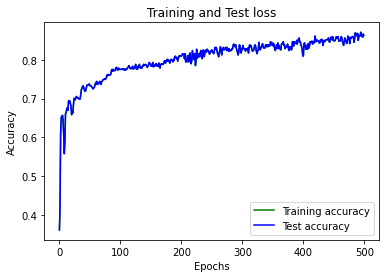

In [8]:
training_loop( 
n_epoch = 500,
optimizer = optimizizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
test_loader = test_loader, 
print_plot = True 
)